In [17]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [2]:
# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths for the images and assign labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        
        # 0 for real, 1 for fake
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# !pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 2.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [5]:
# import patoolib
# patoolib.extract_archive("FINAL_GAN_COMBINED_data (2).zip",outdir="/Downloads")

INFO patool: Extracting FINAL_GAN_COMBINED_data (2).zip ...
INFO patool: ... FINAL_GAN_COMBINED_data (2).zip extracted to `/Downloads'.


'/Downloads'

In [4]:
import os

# Specify the path to the extracted folder
extracted_path = 'final_cleaned_dataset/resized_data'

# List all files and directories in the extracted path
files_and_dirs = os.listdir(extracted_path)

# Display the contents
print(files_and_dirs)

['rezised_fake', '.DS_Store', 'rezised_real']


In [7]:
real_dir = 'final_cleaned_dataset/resized_data/rezised_real'
fake_dir = 'final_cleaned_dataset/resized_data/rezised_fake'

In [8]:
full_dataset = ImageDataset(real_dir, fake_dir, transform=train_transform)

# Getting dataset length
dataset_size = len(full_dataset)

# Splitting into 70% train and 30% for val+test
train_size = int(0.7 * dataset_size)
val_test_size = dataset_size - train_size

# Now spliting val+test into 15% val and 15% test
val_size = int(0.5 * val_test_size)
test_size = val_test_size - val_size

# Creating train, val, and test sets
train_dataset, val_test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

# Creating DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Adjusted the input size of fc1 to match the flattened size
        self.fc1 = torch.nn.Linear(128 * 28 * 28, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, 2)  # Binary classification: real vs fake

        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # Conv Layer 1 with ReLU + Pooling
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))  # Conv Layer 2 with ReLU + Pooling
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))  # Conv Layer 3 with ReLU + Pooling

        x = x.view(-1, 128 * 28 * 28)  # Flatten the output for fully connected layers

        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))  # FC Layer 1 with ReLU + Dropout
        x = self.dropout(torch.nn.functional.relu(self.fc2(x)))  # FC Layer 2 with ReLU + Dropout
        x = self.fc3(x)  # Final output layer

        return x

In [10]:
# Initializing the model
model = CNNModel()

# Moving the model to the GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

def train_model(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=100,    # Number of epochs to train for
    lr=1e-4,          # Learning rate
    patience=10,       # Early stopping patience (number of epochs to wait for improvement)
    model_save_path='best_model_cnn.pth'  # Path to save the best model
):
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_recall = 0.0  # To track the model with the best recall
    best_val_loss = float('inf')  # To track the best validation loss for early stopping
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with tqdm progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images)
                loss = loss_fn(val_outputs, val_labels)

                # Track validation loss and accuracy
                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                # Collect labels and predictions for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        # Calculating average validation loss and accuracy
        epoch_val_loss = val_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculating precision, recall, f1, and support using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
        
        if recall > best_val_recall:
            best_val_recall = recall
            torch.save(model.state_dict(), model_save_path)
            print(f'Best model saved with validation recall: {recall:.4f}')
        

        # Early stopping logic based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break
                
     # Plotting loss and accuracy over epochs
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()            

# Test set evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate precision, recall, f1-score, and confusion matrix for the test set
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}')

    # Confusion matrix visualization for the test set
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot()
    plt.title('Confusion Matrix - Test Set')
    plt.show()
    
    # ROC-AUC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Test Set')
    plt.legend(loc='lower right')
    plt.show()

Epoch 1/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.36it/s]


Epoch [1/100]
Train Loss: 0.5812, Train Accuracy: 0.6881
Val Loss: 0.5458, Val Accuracy: 0.7083
Precision: 0.7328, Recall: 0.6617, F1-Score: 0.6954
Best model saved with validation recall: 0.6617


Epoch 2/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.32it/s]


Epoch [2/100]
Train Loss: 0.5511, Train Accuracy: 0.7009
Val Loss: 0.5192, Val Accuracy: 0.7204
Precision: 0.6965, Recall: 0.7878, F1-Score: 0.7393
Best model saved with validation recall: 0.7878


Epoch 3/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.62it/s]


Epoch [3/100]
Train Loss: 0.5271, Train Accuracy: 0.7159
Val Loss: 0.4953, Val Accuracy: 0.7355
Precision: 0.7380, Recall: 0.7357, F1-Score: 0.7368


Epoch 4/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.38it/s]


Epoch [4/100]
Train Loss: 0.5081, Train Accuracy: 0.7303
Val Loss: 0.4781, Val Accuracy: 0.7355
Precision: 0.7199, Recall: 0.7768, F1-Score: 0.7472


Epoch 5/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.75it/s]


Epoch [5/100]
Train Loss: 0.4953, Train Accuracy: 0.7397
Val Loss: 0.4720, Val Accuracy: 0.7436
Precision: 0.7407, Recall: 0.7548, F1-Score: 0.7476


Epoch 6/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.47it/s]


Epoch [6/100]
Train Loss: 0.4732, Train Accuracy: 0.7530
Val Loss: 0.4568, Val Accuracy: 0.7582
Precision: 0.7645, Recall: 0.7508, F1-Score: 0.7576


Epoch 7/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.57it/s]


Epoch [7/100]
Train Loss: 0.4543, Train Accuracy: 0.7664
Val Loss: 0.4307, Val Accuracy: 0.7743
Precision: 0.7947, Recall: 0.7437, F1-Score: 0.7684


Epoch 8/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.57it/s]


Epoch [8/100]
Train Loss: 0.4382, Train Accuracy: 0.7799
Val Loss: 0.4283, Val Accuracy: 0.7783
Precision: 0.7759, Recall: 0.7868, F1-Score: 0.7813


Epoch 9/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.60it/s]


Epoch [9/100]
Train Loss: 0.4206, Train Accuracy: 0.7826
Val Loss: 0.4156, Val Accuracy: 0.7950
Precision: 0.8096, Recall: 0.7748, F1-Score: 0.7918


Epoch 10/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.67it/s]


Epoch [10/100]
Train Loss: 0.4010, Train Accuracy: 0.7953
Val Loss: 0.3990, Val Accuracy: 0.7889
Precision: 0.7715, Recall: 0.8248, F1-Score: 0.7973
Best model saved with validation recall: 0.8248


Epoch 11/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.77it/s]


Epoch [11/100]
Train Loss: 0.3841, Train Accuracy: 0.8128
Val Loss: 0.4106, Val Accuracy: 0.7980
Precision: 0.7646, Recall: 0.8649, F1-Score: 0.8116
Best model saved with validation recall: 0.8649


Epoch 12/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.63it/s]


Epoch [12/100]
Train Loss: 0.3727, Train Accuracy: 0.8152
Val Loss: 0.3869, Val Accuracy: 0.8065
Precision: 0.8030, Recall: 0.8158, F1-Score: 0.8093


Epoch 13/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.37it/s]


Epoch [13/100]
Train Loss: 0.3616, Train Accuracy: 0.8214
Val Loss: 0.3694, Val Accuracy: 0.8161
Precision: 0.8025, Recall: 0.8418, F1-Score: 0.8217


Epoch 14/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.56it/s]


Epoch [14/100]
Train Loss: 0.3432, Train Accuracy: 0.8319
Val Loss: 0.3880, Val Accuracy: 0.7975
Precision: 0.7798, Recall: 0.8328, F1-Score: 0.8054


Epoch 15/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Epoch [15/100]
Train Loss: 0.3356, Train Accuracy: 0.8360
Val Loss: 0.3558, Val Accuracy: 0.8252
Precision: 0.8333, Recall: 0.8158, F1-Score: 0.8245


Epoch 16/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  7.00it/s]


Epoch [16/100]
Train Loss: 0.3193, Train Accuracy: 0.8529
Val Loss: 0.3714, Val Accuracy: 0.8071
Precision: 0.7790, Recall: 0.8609, F1-Score: 0.8179


Epoch 17/100 [Validation]: 100%|██████████| 63/63 [00:08<00:00,  7.01it/s]


Epoch [17/100]
Train Loss: 0.3132, Train Accuracy: 0.8536
Val Loss: 0.3302, Val Accuracy: 0.8403
Precision: 0.8350, Recall: 0.8509, F1-Score: 0.8428


Epoch 18/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.84it/s]


Epoch [18/100]
Train Loss: 0.2966, Train Accuracy: 0.8566
Val Loss: 0.3417, Val Accuracy: 0.8277
Precision: 0.8120, Recall: 0.8559, F1-Score: 0.8333


Epoch 19/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Epoch [19/100]
Train Loss: 0.2937, Train Accuracy: 0.8602
Val Loss: 0.3277, Val Accuracy: 0.8353
Precision: 0.8692, Recall: 0.7918, F1-Score: 0.8287


Epoch 20/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Epoch [20/100]
Train Loss: 0.2811, Train Accuracy: 0.8658
Val Loss: 0.3367, Val Accuracy: 0.8433
Precision: 0.8606, Recall: 0.8218, F1-Score: 0.8408


Epoch 21/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Epoch [21/100]
Train Loss: 0.2682, Train Accuracy: 0.8738
Val Loss: 0.3289, Val Accuracy: 0.8479
Precision: 0.8242, Recall: 0.8869, F1-Score: 0.8544
Best model saved with validation recall: 0.8869


Epoch 22/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Epoch [22/100]
Train Loss: 0.2718, Train Accuracy: 0.8741
Val Loss: 0.3230, Val Accuracy: 0.8433
Precision: 0.8539, Recall: 0.8308, F1-Score: 0.8422


Epoch 23/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Epoch [23/100]
Train Loss: 0.2577, Train Accuracy: 0.8822
Val Loss: 0.3248, Val Accuracy: 0.8509
Precision: 0.8554, Recall: 0.8468, F1-Score: 0.8511


Epoch 24/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Epoch [24/100]
Train Loss: 0.2467, Train Accuracy: 0.8835
Val Loss: 0.3271, Val Accuracy: 0.8398
Precision: 0.8361, Recall: 0.8478, F1-Score: 0.8419


Epoch 25/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Epoch [25/100]
Train Loss: 0.2452, Train Accuracy: 0.8846
Val Loss: 0.3245, Val Accuracy: 0.8418
Precision: 0.8527, Recall: 0.8288, F1-Score: 0.8406


Epoch 26/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Epoch [26/100]
Train Loss: 0.2382, Train Accuracy: 0.8897
Val Loss: 0.3269, Val Accuracy: 0.8499
Precision: 0.8474, Recall: 0.8559, F1-Score: 0.8516


Epoch 27/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Epoch [27/100]
Train Loss: 0.2296, Train Accuracy: 0.8947
Val Loss: 0.3756, Val Accuracy: 0.8272
Precision: 0.8065, Recall: 0.8639, F1-Score: 0.8342


Epoch 28/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Epoch [28/100]
Train Loss: 0.2236, Train Accuracy: 0.8985
Val Loss: 0.3050, Val Accuracy: 0.8499
Precision: 0.8625, Recall: 0.8348, F1-Score: 0.8484


Epoch 29/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Epoch [29/100]
Train Loss: 0.2216, Train Accuracy: 0.8980
Val Loss: 0.3148, Val Accuracy: 0.8443
Precision: 0.8506, Recall: 0.8378, F1-Score: 0.8442


Epoch 30/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Epoch [30/100]
Train Loss: 0.2177, Train Accuracy: 0.8986
Val Loss: 0.3153, Val Accuracy: 0.8469
Precision: 0.8371, Recall: 0.8639, F1-Score: 0.8502


Epoch 31/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Epoch [31/100]
Train Loss: 0.2179, Train Accuracy: 0.8961
Val Loss: 0.2933, Val Accuracy: 0.8665
Precision: 0.8722, Recall: 0.8609, F1-Score: 0.8665


Epoch 32/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Epoch [32/100]
Train Loss: 0.2000, Train Accuracy: 0.9070
Val Loss: 0.3100, Val Accuracy: 0.8519
Precision: 0.8536, Recall: 0.8519, F1-Score: 0.8527


Epoch 33/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Epoch [33/100]
Train Loss: 0.1990, Train Accuracy: 0.9079
Val Loss: 0.3227, Val Accuracy: 0.8529
Precision: 0.8709, Recall: 0.8308, F1-Score: 0.8504


Epoch 34/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Epoch [34/100]
Train Loss: 0.1950, Train Accuracy: 0.9087
Val Loss: 0.3320, Val Accuracy: 0.8534
Precision: 0.8718, Recall: 0.8308, F1-Score: 0.8508


Epoch 35/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Epoch [35/100]
Train Loss: 0.1880, Train Accuracy: 0.9158
Val Loss: 0.3361, Val Accuracy: 0.8433
Precision: 0.8723, Recall: 0.8068, F1-Score: 0.8383


Epoch 36/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Epoch [36/100]
Train Loss: 0.1805, Train Accuracy: 0.9170
Val Loss: 0.3426, Val Accuracy: 0.8499
Precision: 0.8406, Recall: 0.8659, F1-Score: 0.8531


Epoch 37/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Epoch [37/100]
Train Loss: 0.1803, Train Accuracy: 0.9193
Val Loss: 0.3282, Val Accuracy: 0.8534
Precision: 0.8688, Recall: 0.8348, F1-Score: 0.8515


Epoch 38/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Epoch [38/100]
Train Loss: 0.1848, Train Accuracy: 0.9150
Val Loss: 0.3195, Val Accuracy: 0.8499
Precision: 0.8551, Recall: 0.8448, F1-Score: 0.8499


Epoch 39/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.82it/s]


Epoch [39/100]
Train Loss: 0.1747, Train Accuracy: 0.9245
Val Loss: 0.3336, Val Accuracy: 0.8579
Precision: 0.8574, Recall: 0.8609, F1-Score: 0.8591


Epoch 40/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Epoch [40/100]
Train Loss: 0.1718, Train Accuracy: 0.9201
Val Loss: 0.3384, Val Accuracy: 0.8544
Precision: 0.8515, Recall: 0.8609, F1-Score: 0.8561


Epoch 41/100 [Validation]: 100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Epoch [41/100]
Train Loss: 0.1640, Train Accuracy: 0.9239
Val Loss: 0.3216, Val Accuracy: 0.8534
Precision: 0.8612, Recall: 0.8448, F1-Score: 0.8530
Early stopping triggered after 41 epochs.


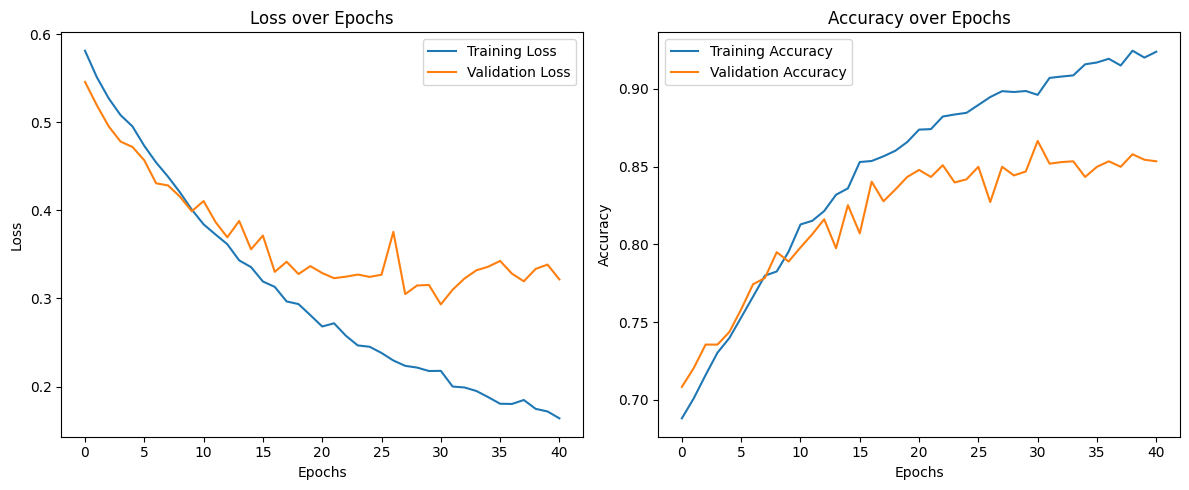

Test Precision: 0.8106, Test Recall: 0.8890, Test F1-Score: 0.8480


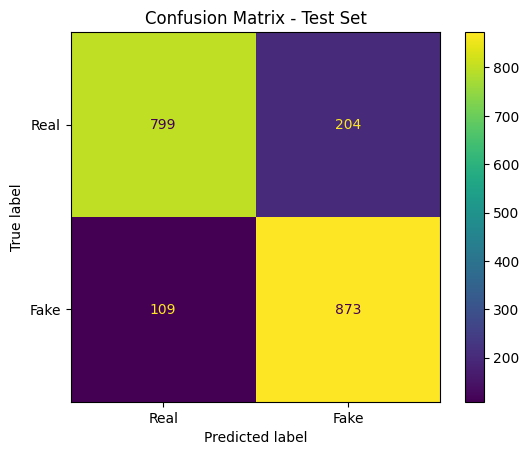

NameError: name 'roc_curve' is not defined

In [16]:
# Training the model with early stopping
train_model(model, train_loader, val_loader, device, num_epochs=100)

# Loading the best model for evaluation
model.load_state_dict(torch.load('best_model_cnn.pth'))